# Tutorial Notebook
#### This notebook gives a tutorial on how to use the realpy package to perform reainforcement learning.
Here, we use the two algorithms in realpy:
#### 1. Gaussian PRocess Batch Upper Confidence Bound (GP-BUCB)
    Use a Gaussian Process model to predict expected metric and subsequently select the inputs that are expected to yield the highest metric. The hyperparameter beta can be tuned to exentuate exploration versus exploitation of the input parameter space.
#### 2. Genetic Algorithm (GA)
    Tests different inputs, or actions, following a genetic algorithm, which maximizes fitness while also including random crossover and mutations.

Both algorithms utilize batch mode. The experiment we will test in this tutorial is to mix different concentrations of red, blue, and green dye to acheive a desired UV/ Vis spectrum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import realpy.UCB.ucb as ucb
import realpy.genetic.genetic as genetic

from sklearn.metrics.pairwise import cosine_similarity

import os
import warnings
import sys

# Initialize and process target data

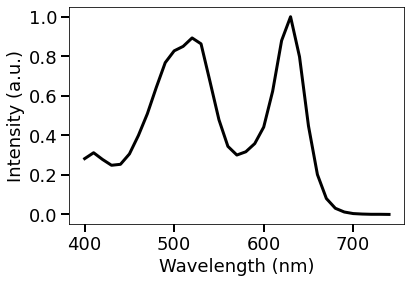

In [2]:
# read in excel file
df = pd.read_excel('target_spectra.xlsx')
data = np.asarray(df)
# get wavelength
wavelength = data[:,0]
# subtract baseline
TARGET = data[:,1] - data[:,2]
# peak normalize spectra
TARGET = TARGET / np.max(TARGET)

# visualizaiton
plt.rcParams.update({'font.size': 18})

# plot target spectra
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(wavelength, TARGET, 'k-', linewidth=3)
# formatting
ax.tick_params(direction='out', width=2, length=8)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.show()

# Read in basis spectra for use in virtual testing

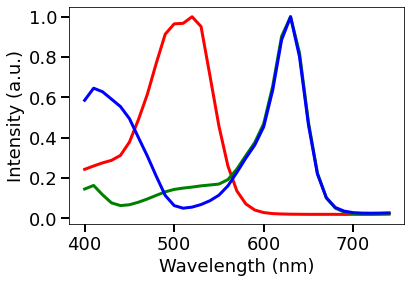

In [3]:
# read in excel file
df = pd.read_excel('basis_spectra.xlsx')
data = np.asarray(df)
# get wavelength
wavelength = data[:,0]
# get colors
RED = data[:,1]
BLUE = data[:,2]
GREEN = data[:,3]
# peak normalize spectra
RED = RED / np.max(RED)
BLUE = BLUE / np.max(BLUE)
GREEN = GREEN / np.max(GREEN)

# visualizaiton
plt.rcParams.update({'font.size': 18})

# plot target spectra
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(wavelength, RED, 'r-', linewidth=3)
plt.plot(wavelength, GREEN, 'g-', linewidth=3)
plt.plot(wavelength, BLUE, 'b-', linewidth=3)
# formatting
ax.tick_params(direction='out', width=2, length=8)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.show()

# 1. Using the GP-BUCB agent

## Initialize Environment

### Requirements:
The environment class must have a sample function that takes in a set of actions and the current time step and produces the corresponding set of results. Two example environment classes are included below.

#### 1. Environment_IO
    This includes functions that read and write data files for actions and results, respectively. Thus, the files can be used as instructions to, for example, an OT2 pipetting robot. This is an example of a environment class that can be used in  a physical experiment.
    
#### 2. Environemt_Virtual
    Instead of reading and wiritng data files, this class computes the result of the actions via a hueristic and would be an example of a virtual testing environment. For the purpose of this tutorial, we will utilize this environment class.

### Example environment with I/O

In [4]:
class Environment_IO(object):
    def __init__(self, target):
        """Initialize environment with target spectrum."""
        self.target = target
   
    def get_cos_sim(self, target, y):
        """Similarity metric to maximize."""
        return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())    
    
    def write_actions(self, actions, time_step):
        """Write batch of actions to csv file."""
        # we are using three dyes
        # therefore the action is a concentration for each of the 3 dyes
        df = pd.DataFrame(actions, columns=['1','2','3'])
        df.to_csv(f'Batch_{time_step + 1}.csv')
        
    def spectra_from_conc(self):
        """Read and write data."""
        # waits for experiment to be performed and takes in the filename of the results 
        print("\ncsv file written with robot instructions. Waiting for experiment...")
        print('What is the csv file name of the experimental results?')
        file_name = input()
        if os.path.exists(file_name):
            # read in excel file
            df = pd.read_excel(file_name)
            data = np.asarray(df)
            # subtract baseline (ignore first colm because it's wavelength)
            results = data[:,1:-1].squeeze() - data[:,-1]
            # peak normalize spectra
            results = results / np.max(results, axis=0)
            return results
        elif file_name == 'END' or file_name == 'STOP':
            warnings.warn("Ending experiment.")
        else:
            warnings.warn(f'{file_name} does not exist')
             
    def sample(self, xs, time_step=0):
        """The agent calls this function during each learning step."""
        self.write_actions(xs, time_step)
        results = self.spectra_from_conc()
        metrics = []
        for result in results:
            metric = self.get_cos_sim(self.target, result)
            metrics.append(metric)
        return np.array(metrics)

### Example environment for virtual testing

In [5]:
class Environment_Virtual(object):
    def __init__(self, target, red, green, blue):
        """Initialize environment with target spectrum."""
        self.target = target
        self.red = red
        self.green = green
        self.blue = blue
   
    def get_cos_sim(self, target, y):
        """Similarity metric to maximize."""
        return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())    
        
    def spectra_from_conc(self,  x):
        """Use beers law to get spectra."""
        # normalize concentrations to add to one
        x = x / np.max(x)
        return x[0]*self.red + x[1]*self.blue + x[2]*self.green
   
    def sample(self, xs, time_step=None):
        """The agent calls this function during each learning step."""
        metrics = []
        for x in xs:
            result = self.spectra_from_conc(x)
            metric = self.get_cos_sim(self.target, result)
            metrics.append(metric)
        return np.array(metrics)

In [6]:
# initializing virtual 
env = Environment_Virtual(TARGET, RED, GREEN, BLUE)

# Initialize experimental constraints

In [7]:
#constraints
min_conc = 0.05
max_conc = 1

# parameter space
N = 20  # grid size

# construct param space
coeffs = np.linspace(min_conc, max_conc, N)
param_space = np.meshgrid(coeffs, coeffs, coeffs)

# Initialize agent

In [8]:
batch_size = 15
UCB_agent = ucb.BatchGPUCB(batch_size, param_space, env, beta=1.5)

# Learn

In [9]:
# training loop
epochs = 6
for i in range(epochs):
    UCB_agent.learn()

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\saman\Downloads\Anaconda\lib\site-pac

# Visualization of Results

In [10]:
def plot_batch_stack(Recomendations, batch_size, epochs):
    
    nrows = epochs//2
    fig, axes = plt.subplots(figsize=(10,15), nrows=nrows, ncols=2)
    fontsize = 16

    total_steps = Recomendations.shape[0]
    
    # formatting loop
    for i, ax in enumerate(axes.flatten()):
        # ticks
        ax.tick_params(direction='out', width=2, length=8)
        ax.tick_params(direction='out', which='minor', width=1, length=5)
        ax.set_yticks([])
        
        if i in [epochs-2, epochs-1]:
            ax.set_xticks(np.arange(300, 701, 100))
            ax.tick_params(axis='x', labelsize=fontsize+2)
            ax.set_xlabel("Wavelength", fontsize=fontsize+6)
        else:
            ax.set_xticks([])
     
    # actually plotting loop
    for i, ax in enumerate(axes.flatten()):
        # target
        ax.plot(wavelength, TARGET, 'k-', linewidth=3, label="Target")
        # get batch
        for action in Recomendations[i]:
            ax.plot(wavelength, env.spectra_from_conc(action), '-',
                     c=action, alpha=0.4)
        # setting legend as batch label
        legend = ax.legend([f'Batch {i+1}'], fontsize=fontsize+4, handlelength=0,
                           handletextpad=0, fancybox=True,)
        for item in legend.legendHandles:
            item.set_visible(False)

    plt.subplots_adjust(hspace=0.0, wspace=0.05)
    plt.show()

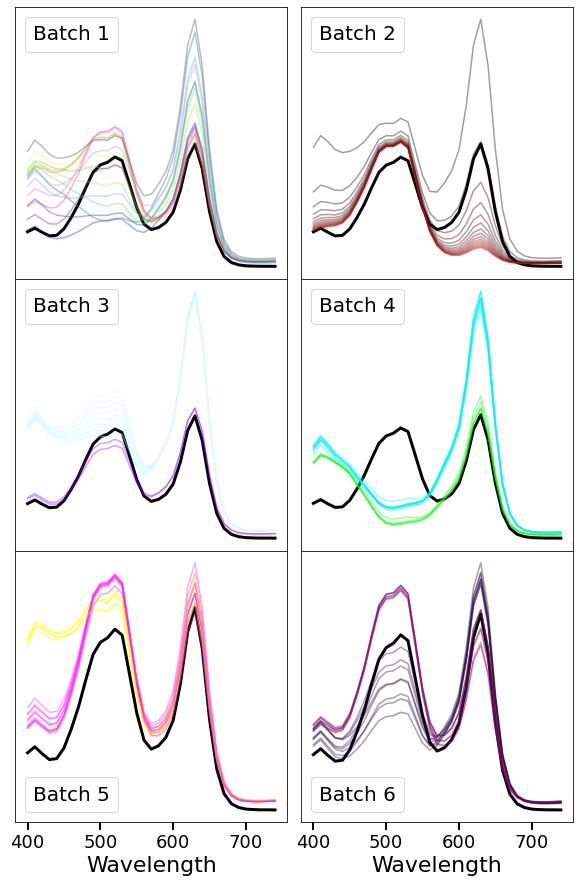

In [68]:
X = np.array(UCB_agent.X)
plot_batch_stack(X, batch_size, epochs)

In [69]:
def plot_batch(Results, actions, wavelength, target, batch_num):
    
    fig, ax = plt.subplots(figsize=(8,6), nrows=1, ncols=1)
    fontsize = 16
    
    # formatting loop
    ax.tick_params(direction='out', width=2, length=8)
    ax.tick_params(direction='out', which='minor', width=1, length=5)
    ax.set_yticks([])
        
    ax.set_xticks(np.arange(300, 701, 100))
    ax.tick_params(axis='x', labelsize=fontsize+2)
    ax.set_xlabel("Wavelength", fontsize=fontsize+6)

    # target
    ax.plot(wavelength, target, 'k-', linewidth=3, label="Target")
    for i, spectrum in enumerate(Results):
        ax.plot(wavelength, spectrum, '-', c=actions[i], alpha=0.4)
    # setting legend as batch label
    legend = ax.legend([f'Batch {batch_num}'], fontsize=fontsize+4, handlelength=0,
                        handletextpad=0, fancybox=True,)
    for item in legend.legendHandles:
        item.set_visible(False)

    plt.subplots_adjust(hspace=0.0, wspace=0.05)
    plt.show()

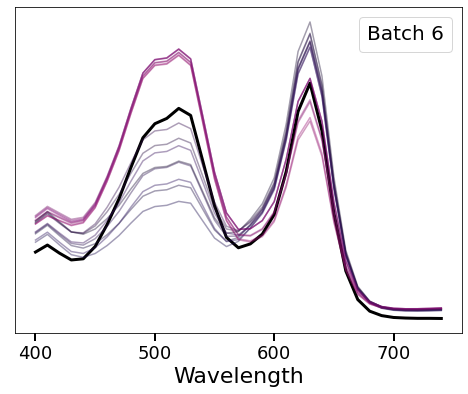

In [70]:
actions = np.array(UCB_agent.X[-1])
Results = [env.spectra_from_conc(action) for action in actions]
Results = np.array(Results)
plot_batch(Results, actions, wavelength, TARGET, epochs)

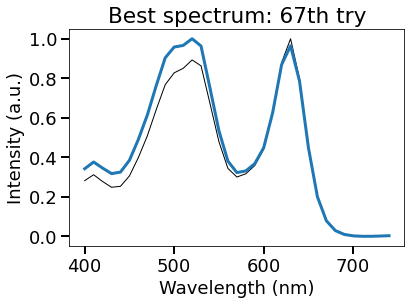

In [71]:
def plot_best_spectrum(X, Y, batch_size):
    best_idx = np.argmax(Y)
    batch_num = best_idx // batch_size
    action = X[batch_num, best_idx%batch_size, :]
    best_spectrum = env.spectra_from_conc(action)

    best_spectrum = best_spectrum - np.min(best_spectrum)
    best_spectrum = best_spectrum / np.max(best_spectrum)

    # plot target spectra
    fig, ax = plt.subplots(figsize=(6,4))
    plt.plot(wavelength, TARGET, 'k-', linewidth=1)
    plt.plot(wavelength, best_spectrum, linewidth=3)
    # formatting
    ax.tick_params(direction='out', width=2, length=8)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity (a.u.)")
    plt.title(f"Best spectrum: {best_idx}th try")
    plt.show()
    
plot_best_spectrum(X, UCB_agent.Y, batch_size)

# Using the Genetic Algorithm (GA)

The first iteration, i.e, generation, will use a Latin hypercube sampling. Thus, the agent will randomle sample in a (hyper)grid of the parameter space. For consistency, we will use the same sampling as the GP-BUCB agent.

In [46]:
# get LH sampling of input space
first_generation_actions = UCB_agent.X[0]

## Initialize agent

In [74]:
# use the same batch_size and Environment_Virtual class as the GP-BUCB agent
# the first generation must be the spectra of the first (zeroth iteration) batch
ga_agent = genetic.GA(env, batch_size, first_generation_actions)

## Learn

In [75]:
# same number of epochs as the GP-BUCB agent (6)

for i in range(epochs):
    ga_agent.learn()

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\saman\Downloads\Anaconda\lib\site-pac

## Visualization of Results

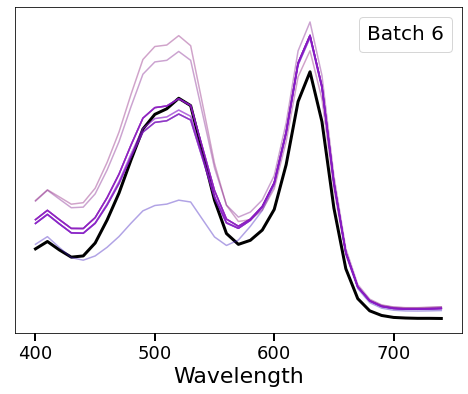

In [76]:
actions = ga_agent.generation
Results = [env.spectra_from_conc(action) for action in actions]
Results = np.array(Results)
plot_batch(Results, actions, wavelength, TARGET, i+1)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\saman\Downloads\Anaconda\lib\site-pac

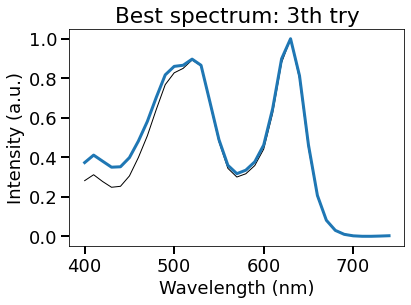

In [77]:
actions = np.array(actions)
actions = actions.reshape(1, batch_size, 3)
plot_best_spectrum(actions, ga_agent.fitness(), batch_size)